- 和歌山県を担当
- 中間レポートに引き続き、分析に際して発生した成果物は https://github.com/kod-y/IndGeo_Mid に保存されています

# データ取得・前処理

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import powerlaw

## 和歌山県版産業連関表の前処理

In [55]:
data = pd.read_excel("https://www.pref.wakayama.lg.jp/prefg/020300/sangyo/h27/d00203979_d/fil/t_107.xlsx",
                     index_col=1, skiprows=3)

In [56]:
chemical = data[data.loc[:, 'Unnamed: 0'].isin([201, 202, 203, 204, 205, 206, 207, 208])].index

In [57]:
df = data.drop(columns=['Unnamed: 0', 'Unnamed: 125'], inplace=False)  # Drop unnecessary columns
df.columns = [column.replace('\n', '') for column in df.columns]  # Remove line breaks from column names

In [58]:
def merge_some_industries(df:pd.DataFrame, new_industry_name:str, industries:list):
    """
    Merge some industries into one industry.
    df: input dataframe
    industries: industries to merge (str)
    """
    df = df.copy()
    # add a new row and column into the first row and column
    df.loc[:, industries[0]] = df.loc[:, industries].sum(axis=1)
    df.loc[industries[0], :] = df.loc[industries, :].sum(axis=0)

    # drop unnecessary columns and rows
    df.drop(columns=industries[1:], inplace=True)
    df.drop(index=industries[1:], inplace=True)

    # rename the new row and column
    if new_industry_name is not None:
        df.rename(index={industries[0]: new_industry_name}, inplace=True)
        df.rename(columns={industries[0]: new_industry_name}, inplace=True)

    return df

In [59]:
df = merge_some_industries(df, '化学製品', chemical)
df = merge_some_industries(df, '石油・石炭製品', ['石油製品', '石炭製品'])
df = merge_some_industries(df, '非鉄金属', ['非鉄金属製錬・精製', '非鉄金属加工製品'])
df = merge_some_industries(df, '乗用車・その他の自動車', ['乗用車', 'その他の自動車'])
df = merge_some_industries(df, '繊維製品', ['繊維工業製品', '衣服・その他の繊維既製品'])
df = merge_some_industries(df, '飼料・有機肥料・たばこ', ['飼料・有機質肥料（別掲を除く。）', 'たばこ'])

In [60]:
df.to_csv('../../data/final/df_processed.csv')

## 全国版産業連関表の前処理

In [61]:
data_jp = pd.read_excel('https://www.e-stat.go.jp/stat-search/file-download?statInfId=000031839447&fileKind=0',
                        skiprows=2, index_col=1)

In [62]:
df_jp = data_jp.drop(columns=['Unnamed: 0'], inplace=False)  # Drop unnecessary columns

In [63]:
df_jp = merge_some_industries(df_jp, '化学製品', chemical)
df_jp = merge_some_industries(df_jp, '石油・石炭製品', ['石油製品', '石炭製品'])
df_jp = merge_some_industries(df_jp, '非鉄金属', ['非鉄金属製錬・精製', '非鉄金属加工製品'])
df_jp = merge_some_industries(df_jp, '乗用車・その他の自動車', ['乗用車', 'その他の自動車'])
df_jp = merge_some_industries(df_jp, '繊維製品', ['繊維工業製品', '衣服・その他の繊維既製品'])
df_jp = merge_some_industries(df_jp, '飼料・有機肥料・たばこ', ['飼料・有機質肥料（別掲を除く。）', 'たばこ'])

In [64]:
df_jp.to_csv('../../data/final/data_jp_processed.csv')

# 個人作業

In [65]:
def IO_network(IOtable, n_industry):
    industries = [industry for industry in IOtable.index[:n_industry] if IOtable.at['内生部門計', industry] != 0]
    frame = IOtable.loc[industries, industries].apply(lambda x: x / sum(x))  # ratio of each element to the sum of the row
    for row in industries:
        for col in industries:
            if frame.at[row, col] < 0.01:
                frame.at[row, col] = 0

    return frame, industries

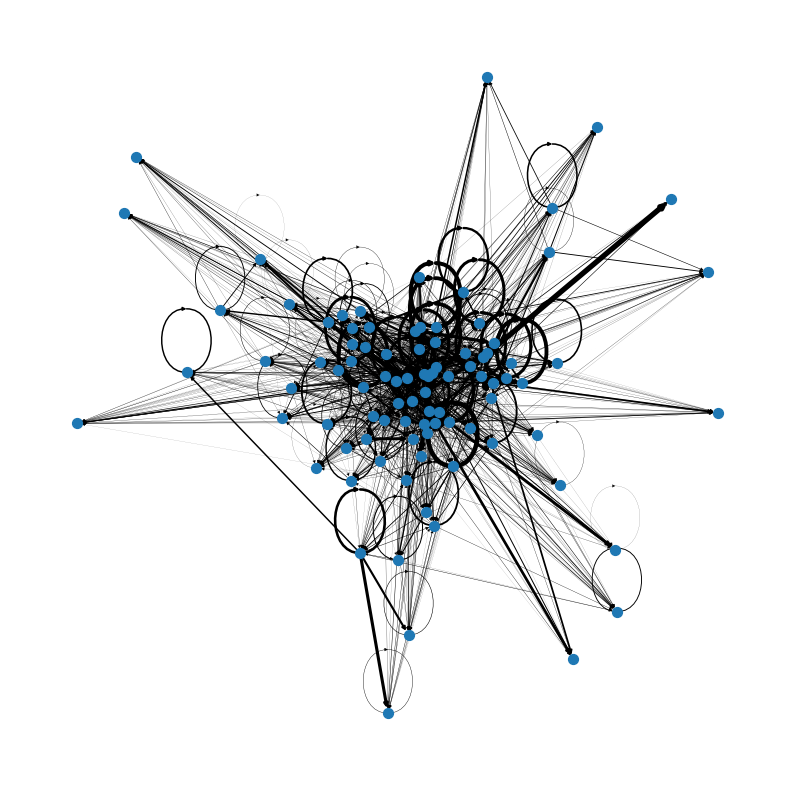

In [66]:
# Get the adjacency matrix from the IO table
n_industry = 95
W, industries = IO_network(df, n_industry)

# Draw the network from the adjacency matrix
# G = nx.from_numpy_matrix(W.values, create_using=nx.DiGraph)
G = nx.DiGraph(W.values)

# Visualize the network
fig, ax = plt.subplots(figsize=(10, 10))
weights = [5 * df['weight'] for _, _, df in G.edges(data=True)]
nx.draw(G, node_size=50, arrowsize=5, width=weights, ax=ax)

In [67]:
# Calculate in-degree and out-degree
measures = pd.DataFrame(index=industries)
for v, industry in enumerate(industries):
    measures.at[industry, 'in-degree'] = G.in_degree(v)
    measures.at[industry, 'out-degree'] = G.out_degree(v)

In [68]:
# Calculate the mean of out-degree
measures['out-degree'].mean()

# Calculate the density
G.number_of_edges() / (G.number_of_nodes() * (G.number_of_nodes() - 1))

0.17224080267558528

In [69]:
# Calculate strength
for v, industry in enumerate(industries):
    measures.at[industry, 'out-strength'] = G.out_degree(v, weight='weight')

c:\Users\echo1\Documents\Python_Analysis\venv_IndGeo\venv_IndGeo\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


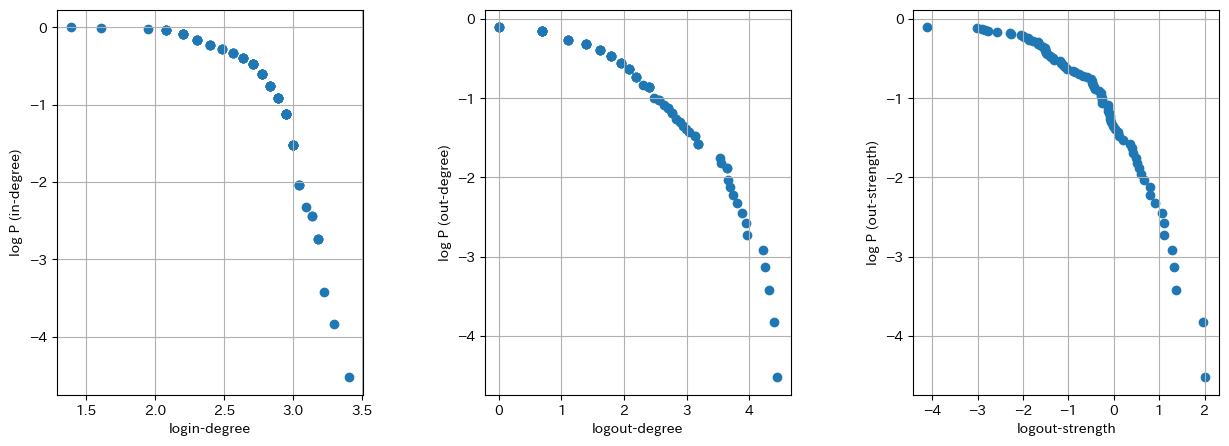

In [70]:
# Check whether in-degree, out-degree and out-strength follow power-law distribution
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax.flatten()
for i, measure in enumerate(['in-degree', 'out-degree', 'out-strength']):
    ccd = measures[measure].apply(lambda x: len(measures[measures[measure] >= x]) / len(measures))

    ax[i].scatter(x=np.log(measures[measure]), y=np.log(ccd))
    ax[i].set_xlabel('log' + measure)
    ax[i].set_ylabel('log P (' + measure + ')')
    ax[i].grid()

fig.subplots_adjust(wspace=0.4)

In [71]:
# Kolmogorov–Smirnov test
def ks_test(measure):
    if 'degree' in measure:
        discrete = True
    else:
        discrete = False

    result = powerlaw.Fit(measures[measure], discrete=discrete, verbose=False)
    fitted_dist = powerlaw.Power_Law(xmin=result.xmin, parameters=[result.alpha], discrete=discrete)
    ks = fitted_dist.KS(data=measures[measure])
    kss = []

    for i in range(2500):
        data_synthetic = fitted_dist.generate_random(len(measures[measure]))
        result_synthetic = powerlaw.Fit(data_synthetic, discrete=discrete, verbose=False)
        fitted_dist_synthetic = powerlaw.Power_Law(xmin=result_synthetic.xmin, parameters=[result_synthetic.alpha], discrete=discrete)
        kss.append(fitted_dist_synthetic.KS(data_synthetic))

    p_value = len([x for x in kss if x >= ks]) / len(kss)

    return kss, ks, p_value

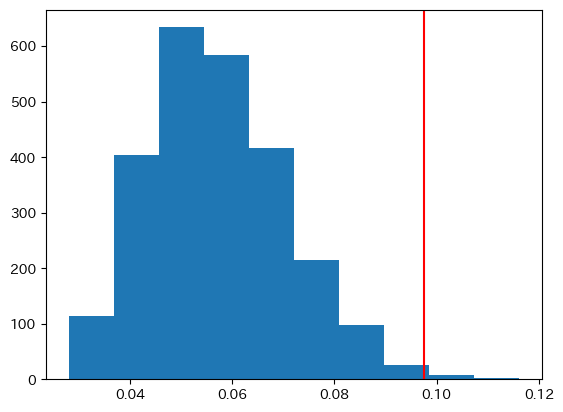

In [72]:
fig, ax = plt.subplots()
ax.hist(ks_test('out-strength')[0])
ax.axvline(ks_test('out-strength')[1], color='red')

In [73]:
pd.DataFrame({measure: ks_test(measure)[2] for measure in measures.columns}, index=['p_value'])

,in-degree,out-degree,out-strength
p_value,0.3872,0.0044,0.0052


In [74]:
# Calculate the shortest path length of the network that is strongly connected
val = 0
for C in (G.subgraph(c) for c in nx.strongly_connected_components(G)):
    val += nx.average_shortest_path_length(C) * C.number_of_nodes() / G.number_of_nodes()
print(val)

1.9657402311502479


In [75]:
# Clustering coefficient
G_cc = nx.average_clustering(G)
print(G_cc)

0.3707904746162273


In [76]:
# Calculate the clustering coefficient of 1000 randomly-generated networks
ccs = []
for i in range(1000):
    g = nx.directed_configuration_model([G.in_degree(v) for v in G.nodes], [G.out_degree(v) for v in G.nodes], create_using=nx.DiGraph)
    ccs.append(nx.average_clustering(g))

# Report the max one
max(ccs)

0.23962443806653055

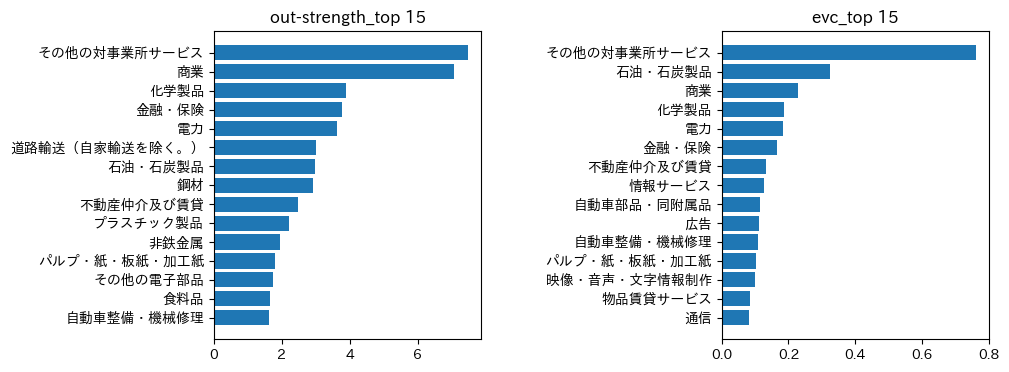

In [77]:
# Calculate eigenvector centrality
evcs = nx.eigenvector_centrality(G.reverse(), weight='weight')
for v, industry in enumerate(industries):
    measures.at[industry, 'evc'] = evcs[v]

# Compare the top 15 industries of eigenvector centrality and out-strength
industries0 = [industry for industry in industries if df.loc['雇用者所得', industry].sum() != 0]  # Remove industries where the employers' income is zero

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()
num = 15
for i, measure in enumerate(['out-strength', 'evc']):
    vec = measures.loc[industries0, measure].sort_values()
    axes[i].barh(vec[-num:].index, vec[-num:])
    axes[i].set_title(measure + '_top ' + str(num))
fig.subplots_adjust(wspace=0.9)

In [78]:
# Do the KS test for eigenvector centrality
ks_test('evc')[2]

0.0276

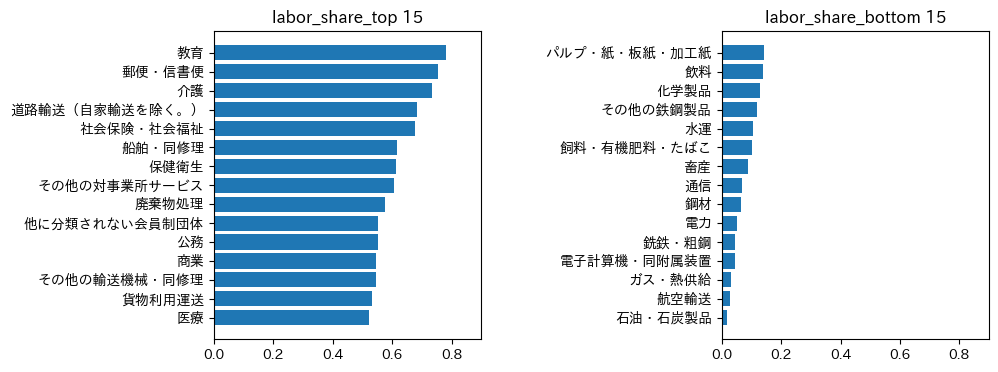

In [79]:
# Calculate the influence vector
## Get \alpha
alphas = df.loc[['雇用者所得'], industries].sum() / df.loc[['雇用者所得', '内生部門計'], industries].sum()

for industry in industries:
    measures.at[industry, 'alpha'] = alphas[industry]

## Check the top 15 industries of alpha
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()
vec = measures.loc[industries0, 'alpha'].sort_values()
num = 15
axes[0].barh(vec[-num:].index, vec[-num:])
axes[1].barh(vec[:num].index, vec[:num])
axes[0].set_title('labor_share_top ' + str(num))
axes[1].set_title('labor_share_bottom ' + str(num))
axes[0].set_xlim([0, 0.9])
axes[1].set_xlim([0, 0.9])
fig.subplots_adjust(wspace=0.9)

c:\Users\echo1\Documents\Python_Analysis\venv_IndGeo\venv_IndGeo\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


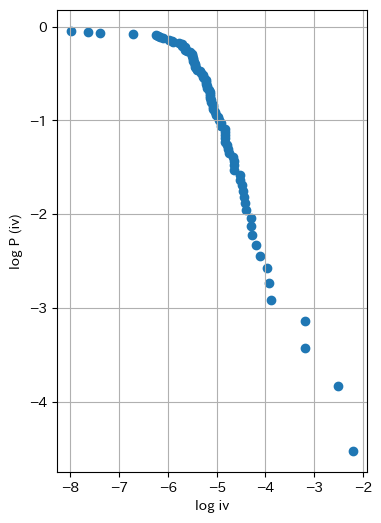

In [80]:
# Check whether the influence vector follows power-law distribution
n_industry = len(industries)
alpha_hat = np.zeros_like(W)

for i, industry in enumerate(industries):
    alpha_hat[i, i] = alphas[industry]

A = np.zeros_like(W)

for i, row in enumerate(industries):
    for j, col in enumerate(industries):
        A[i, j] = (1 - alphas[col]) * W.at[row, col]

iv = alpha_hat @ np.linalg.inv(np.identity(n_industry) - A) @ np.ones(n_industry) / n_industry

for i, industry in enumerate(industries):
    measures.at[industry, 'iv'] = iv[i]

fig, ax = plt.subplots(figsize=(4, 6))
ccd = measures['iv'].apply(lambda x: len(measures[measures['iv'] >= x]) / len(measures))
ax.scatter(x=np.log(measures['iv']), y=np.log(ccd))
ax.set_xlabel('log iv')
ax.set_ylabel('log P (iv)')
ax.grid()

In [81]:
# Do the KS test for influence vector
ks_test('iv')[2]

0.2176

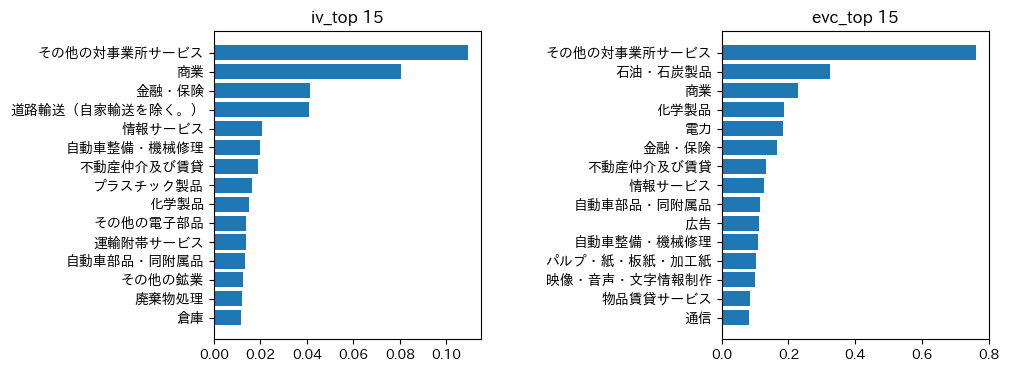

In [82]:
# Check the top 15 industries of influence vector
# Compare it with the top 15 industries of eigenvector centrality at the same time
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()
num = 15

for i, measure in enumerate(['iv', 'evc']):
    vec = measures.loc[industries0, measure].sort_values()
    axes[i].barh(vec[-num:].index, vec[-num:])
    axes[i].set_title(measure + '_top ' + str(num))

fig.subplots_adjust(wspace=0.9)

# 新しい中心性

## 媒介中心性

c:\Users\echo1\Documents\Python_Analysis\venv_IndGeo\venv_IndGeo\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


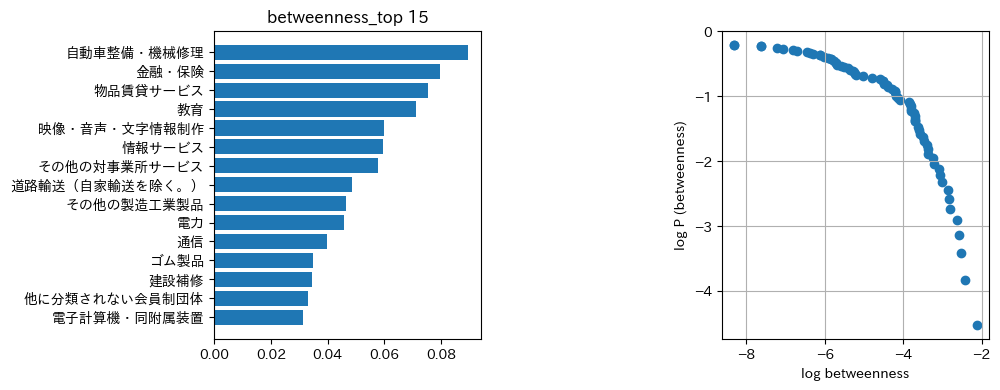

In [83]:
betweenness = nx.betweenness_centrality(G, weight='weight')
for v, industry in enumerate(industries):
    measures.at[industry, 'betweenness'] = betweenness[v]

# Check the top 15 industries of betweenness and whether it follows power-law distribution
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()
num = 15

# Top 15 industries of betweenness
vec = measures.loc[industries0, 'betweenness'].sort_values()
axes[0].barh(vec[-num:].index, vec[-num:])
axes[0].set_title('betweenness_top ' + str(num))

# Check whether betweenness follows power-law distribution
ccd = measures['betweenness'].apply(lambda x: len(measures[measures['betweenness'] >= x]) / len(measures))
axes[1].scatter(x=np.log(measures['betweenness']), y=np.log(ccd))
axes[1].set_xlabel('log betweenness')
axes[1].set_ylabel('log P (betweenness)')
axes[1].grid()

fig.subplots_adjust(wspace=0.9)

In [85]:
# Do the KS test for betweenness
ks_test('betweenness')[2]

0.0052

$p < 1$なので帰無仮説は棄却される